In [1]:
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
import scipy.cluster.hierarchy as sch

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from typing import Callable

/home/aveitsme/envs/core/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# General functions

In [2]:
def unique_report(sample: pd.DataFrame | pd.Series, features: list[str]) -> None:
    """Print feature, count of unique values & unique values"""
    for feature in features:
        print(
            f"Feature: {feature}\n \
            Unique values count: {sample[feature].unique().shape}\n \
            Unique values: {sample[feature].unique()}\n"
        )

def plot_hists_box(sample: pd.DataFrame | pd.Series, features: list[str]) -> None:
    """Plot hist & plot for every feature in list"""
    for feature in features:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        sns.histplot(data=sample, x=feature, ax=ax[0])
        sns.boxplot(data=sample, x=feature, ax=ax[1])

def plot_feature_importance(model, predictors, model_name):
    """Plot feature importance"""
    feature_imp=pd.DataFrame(sorted(zip(model.feature_importances_, predictors.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title(f"{model_name} Most Important Features")
    plt.tight_layout()
    plt.show()

# Special functions

In [3]:
OPTUNA_EARLY_STOPING = 20

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    """Represents exception class that raised to stop tuning"""
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    """Callback to stop tuning if score remain the same"""
    if EarlyStoppingExceeded.best_score == None:
        EarlyStoppingExceeded.best_score = study.best_value
    elif study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
        if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
        else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    return

class Optimizer:
    """Represents class to tune hyper parameters using optuna"""
    def __init__(self, train_x, train_y, model_class, scoring="f1", cv=5):
        self.train_x = train_x
        self.train_y = train_y
        self.model_class = model_class
        self.scoring = scoring
        self.cv = cv

    def _objective(self, trial):
        """Objective function to tune hyperparameters"""
        search_space = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "learning_rate": trial.suggest_float("learning_rate", 1e-8, 0.125),
            "max_depth": trial.suggest_int("max_depth", 2, 9),
            "subsample": trial.suggest_float("subsample", .5, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, 1)
        }
        model = self.model_class(**search_space)
        cross_valid_scores = cross_val_score(model, self.train_x, self.train_y, cv=5, scoring=self.scoring)

        return cross_valid_scores.mean()

    def run(self):
        """Run hyperparameters tuning"""
        study = optuna.create_study(direction="maximize", study_name="test")
        func = lambda trial: self._objective(trial)
        try:
            study.optimize(func, n_trials=100, show_progress_bar=True, callbacks=[early_stopping_opt])
        except EarlyStoppingExceeded:
             print(f"EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}")
        return study.best_trial

def train(model_class, predictors, target) -> float:
    """
        Get optimal hyper parameters & fit model
        Return f1_score & model
    """
    train_x, test_x, train_y, test_y = train_test_split(
        predictors,
        target,
        test_size=.2
    )
    optimizer = Optimizer(train_x, train_y, XGBClassifier)
    best_trial = optimizer.run()
    model = model_class(**best_trial.params).fit(train_x, train_y)
    pred_y = model.predict(test_x)
    return [f1_score(test_y, pred_y), model]

# Variables

In [4]:
RAW = "raw/train.csv"
PREPROCESSED = "preprocessed/train.csv"
TARGET = "Transported"

In [5]:
sample = pd.read_csv(RAW)

# Explore data

In [6]:
sample.shape

(8693, 14)

In [7]:
sample.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
sample.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
sample.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [11]:
unique_report(sample, sample.columns)

Feature: PassengerId
             Unique values count: (8693,)
             Unique values: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

Feature: HomePlanet
             Unique values count: (4,)
             Unique values: ['Europa' 'Earth' 'Mars' nan]

Feature: CryoSleep
             Unique values count: (3,)
             Unique values: [False True nan]

Feature: Cabin
             Unique values count: (6561,)
             Unique values: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Feature: Destination
             Unique values count: (4,)
             Unique values: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]

Feature: Age
             Unique values count: (81,)
             Unique values: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 

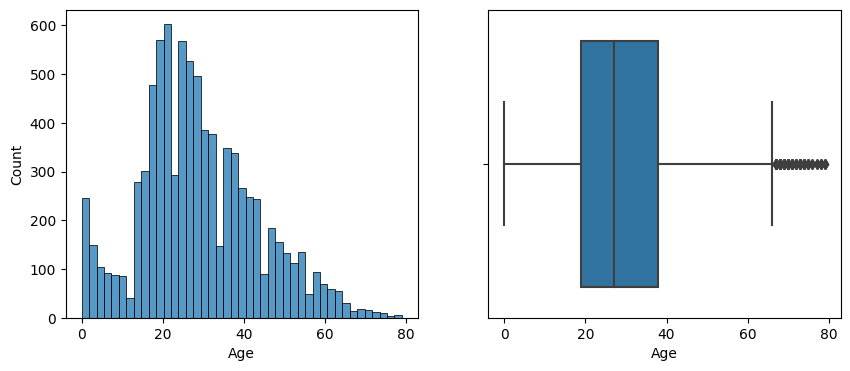

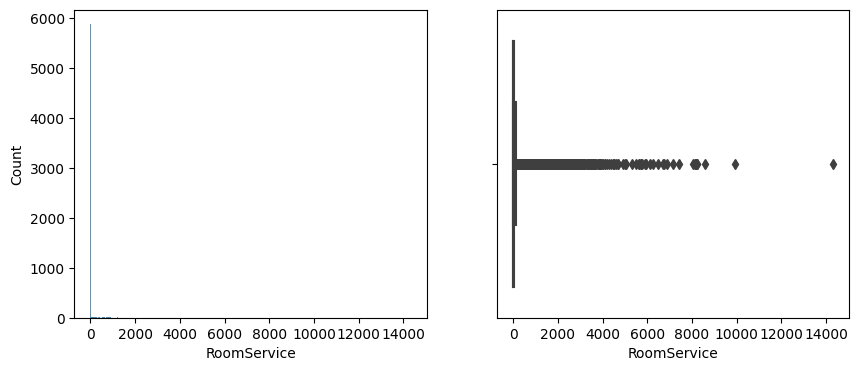

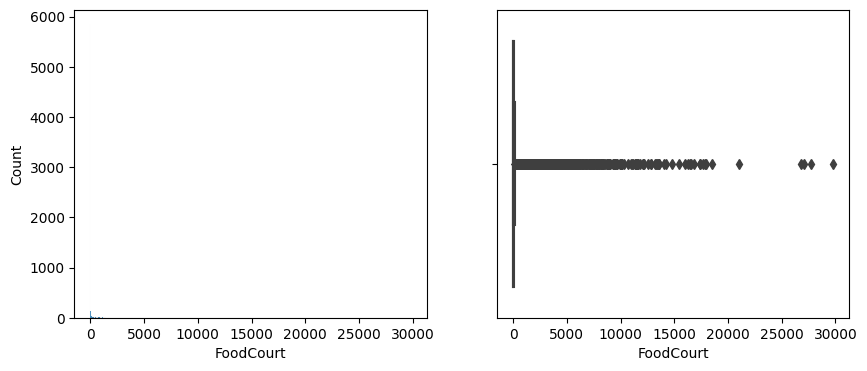

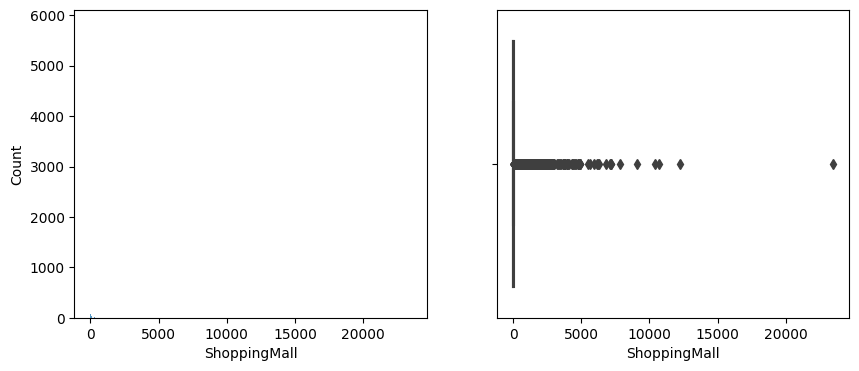

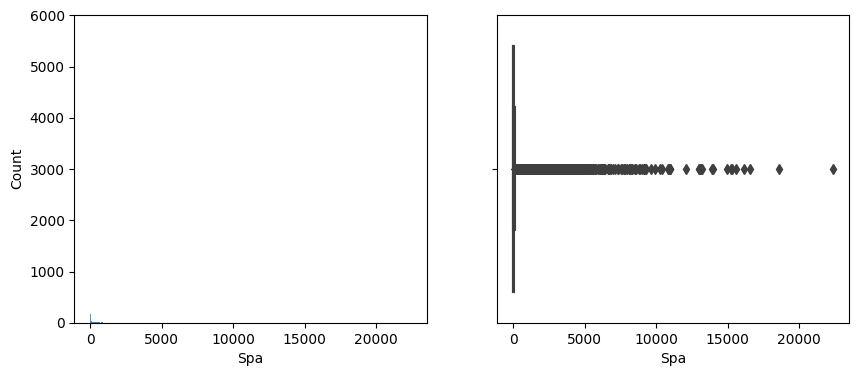

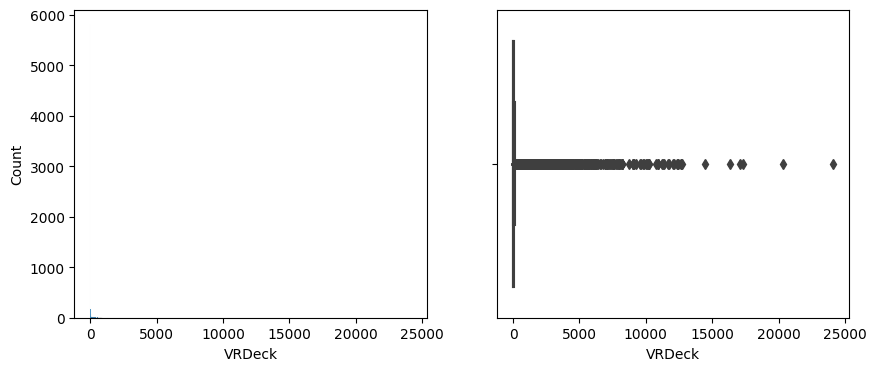

In [12]:
numeric_cols = sample.select_dtypes('number').columns 
plot_hists_box(sample, numeric_cols)

# First look

- General
    * NaN values
    * Outliers
    * Hidden features
    * Wrong dtypes

# Outliers & NaN values

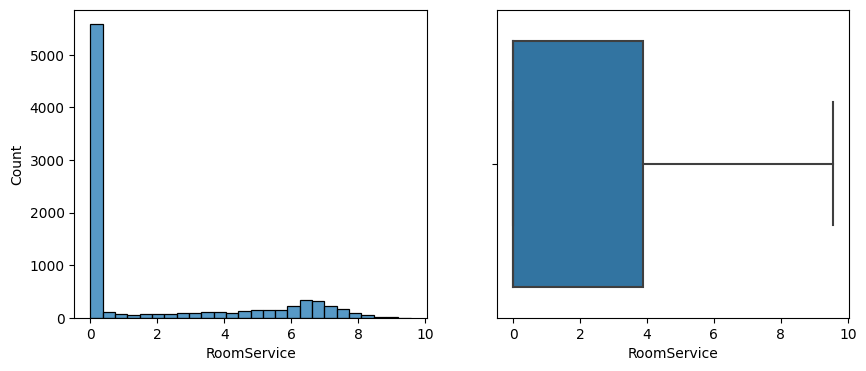

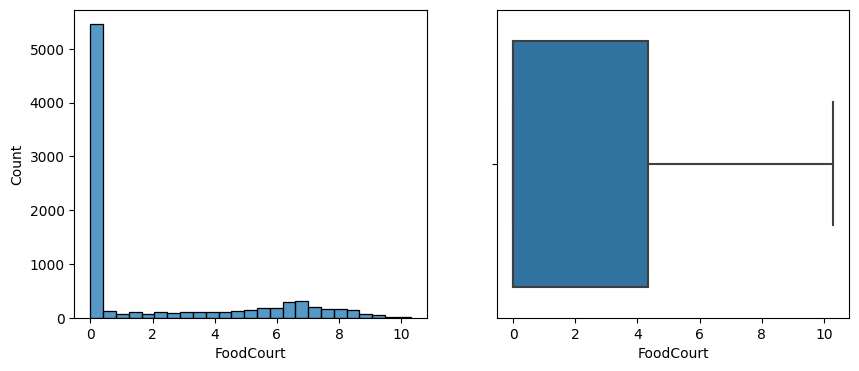

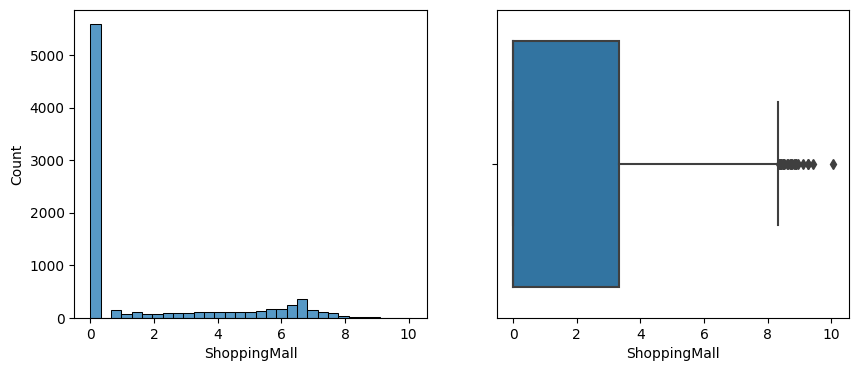

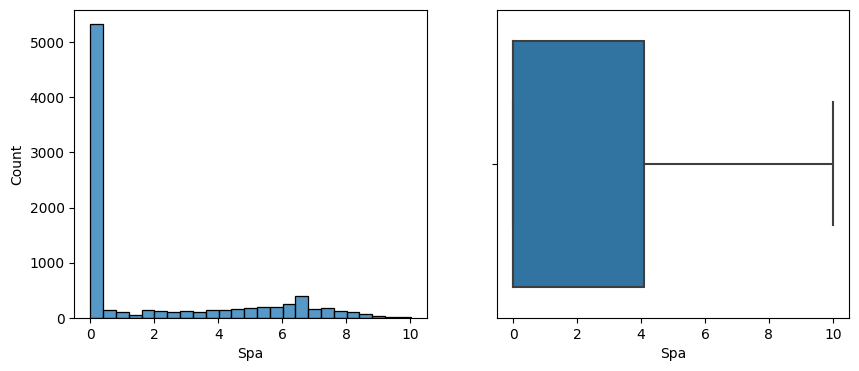

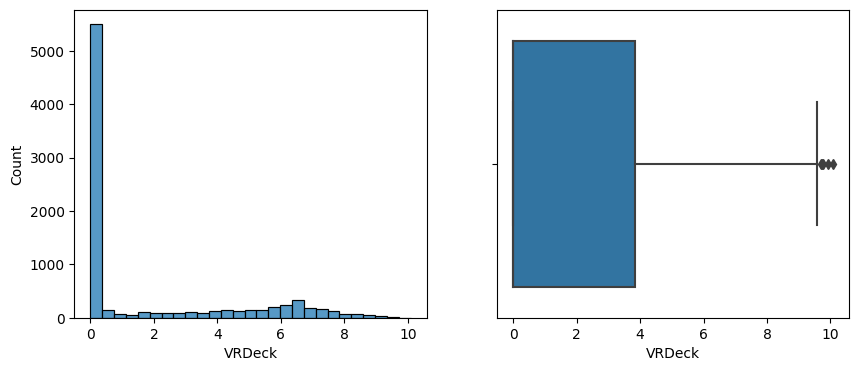

In [13]:
out_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
sample.loc[:, out_cols] = np.log(sample.loc[:, out_cols] + 1) 
plot_hists_box(sample, out_cols)

There are a lot of outliers.
<br> 
So the simplest solution according to distributions (Looks like there is two different classes) is to replace values of all these features with:
   - 0 - didn't spent money
   - 1 - spent money

In this case, i don't see the way to process NaN values. So, KISS, drop NA (If you have a better solution, please, tell me).

In [14]:
sample = sample.dropna()

In [15]:
sample.shape

(6606, 14)

In [16]:
for col in out_cols:
    sample[col] = sample.loc[:, col].apply(lambda x: 0 if x == 0.0 else 1)

# Wrong dtypes

Age: I'm going to use catboost encoder for categorical (bin counts), so I think that converting age to categorical is not such a bad idea. 
<br>
As I said, there are a couple wrong dtypes, let's fix it!  

In [17]:
sample[TARGET] = sample[TARGET].astype(int)
sample["Age"] = sample["Age"].astype(str)
sample["CryoSleep"] = sample["CryoSleep"].astype(int) 
sample["VIP"] = sample["VIP"].astype(int)

In [18]:
sample.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

# Categorical features

Cabin description: "Takes the form deck/num/side, where side can be either P for Port or S for Starboard."
<br>
So we can split this value by '/' and get 3 new features!

In [19]:
sample[["deck", "num", "side"]] = sample["Cabin"].str.split('/', expand=True)
sample[["deck", "num", "side"]]

,deck,num,side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


Id description: "Each Id takes the form gggg_pp where gggg indicates a group the passenger..." 
<br>
We don't really need unique number of passenger, but we can extract his group. 

In [20]:
sample["Group"] = sample["PassengerId"].str.split('_', expand=True)[0]
sample["Group"]

We can use surname as indicator of family.
<br>
Although there could be namesakes, we extracted groups, which could help us indicate families. 

In [21]:
sample["Surname"] = sample["Name"].str.split(' ', expand=True)[1]
sample["Surname"]

In [22]:
sample = sample.drop(columns = ["Cabin", "Name", "PassengerId"])

# Look at the unique values again

In [23]:
str_cols = sample.select_dtypes('object').columns
unique_report(sample, str_cols)

Feature: HomePlanet
             Unique values count: (3,)
             Unique values: ['Europa' 'Earth' 'Mars']

Feature: Destination
             Unique values count: (3,)
             Unique values: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']

Feature: Age
             Unique values count: (80,)
             Unique values: ['39.0' '24.0' '58.0' '33.0' '16.0' '44.0' '26.0' '35.0' '14.0' '45.0'
 '32.0' '48.0' '28.0' '0.0' '1.0' '49.0' '10.0' '7.0' '15.0' '34.0' '43.0'
 '47.0' '2.0' '23.0' '20.0' '17.0' '55.0' '4.0' '21.0' '56.0' '25.0'
 '38.0' '27.0' '36.0' '22.0' '62.0' '18.0' '19.0' '37.0' '42.0' '13.0'
 '40.0' '3.0' '54.0' '9.0' '6.0' '29.0' '64.0' '67.0' '61.0' '50.0' '31.0'
 '8.0' '51.0' '11.0' '41.0' '30.0' '46.0' '60.0' '63.0' '57.0' '5.0'
 '79.0' '68.0' '59.0' '74.0' '12.0' '65.0' '53.0' '71.0' '52.0' '75.0'
 '76.0' '78.0' '70.0' '73.0' '66.0' '69.0' '72.0' '77.0']

Feature: deck
             Unique values count: (8,)
             Unique values: ['B' 'F' 'A' 'G' 'E' 'C' 'D' 

# Run catboost encoder to process categorical

In [27]:
encoder = ce.cat_boost.CatBoostEncoder()
encoder.fit(sample[str_cols], sample[TARGET])
sample[str_cols] = encoder.transform(sample.loc[:, str_cols])

# Look at the data

In [38]:
sample.head(20)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,Group,Surname
0,0.659799,0,0.466791,0.421330,0,0,0,0,0,0,0,0.728941,0.423356,0.449878,0.503633,0.503633
1,0.425709,0,0.466791,0.443374,0,1,1,1,1,1,1,0.435441,0.423356,0.556038,0.503633,0.875908
2,0.659799,0,0.466791,0.430656,1,1,1,0,1,1,0,0.487998,0.423356,0.556038,0.167878,0.583939
3,0.659799,0,0.466791,0.445679,0,0,1,1,1,1,0,0.487998,0.423356,0.556038,0.167878,0.583939
4,0.425709,0,0.466791,0.566701,0,1,1,1,1,1,1,0.435441,0.731049,0.556038,0.503633,0.583939
5,0.425709,0,0.505615,0.511277,0,0,1,0,1,0,1,0.435441,0.423356,0.449878,0.503633,0.500727
6,0.425709,0,0.466791,0.507160,0,1,1,1,0,0,1,0.435441,0.437954,0.556038,0.503633,0.250606
8,0.425709,0,0.466791,0.496350,0,0,1,1,1,0,1,0.435441,0.700242,0.556038,0.503633,0.417272
9,0.659799,1,0.622517,0.534814,0,0,0,0,0,0,1,0.728941,0.731049,0.449878,0.834544,0.834544
11,0.659799,0,0.622517,0.458954,0,1,1,1,1,1,1,0.728941,0.731049,0.449878,0.834544,0.834544


# Look at the target balance (Because I removed a lot of data)
It's ok

<AxesSubplot: >

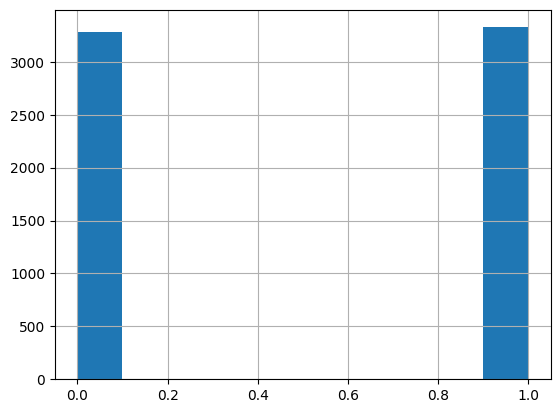

In [29]:
sample["Transported"].hist()

In [49]:
sample.to_csv(PREPROCESSED)

# Prepare data to train

In [43]:
predictors = sample.loc[:, sample.columns != "Transported"]
target = sample["Transported"]

# Train LGBM

In [44]:
score, model = train(LGBMClassifier, predictors, target)
print(f"\nTEST SCORE IS {score}")

[I 2022-12-08 01:15:23,889] A new study created in memory with name: test
/home/aveitsme/envs/core/lib/python3.10/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  1%|▋                                                              | 1/100 [00:02<04:31,  2.74s/it]

[I 2022-12-08 01:15:26,632] Trial 0 finished with value: 0.8368720610231655 and parameters: {'n_estimators': 389, 'learning_rate': 0.05129377240526179, 'max_depth': 8, 'subsample': 0.7732898862697479, 'min_child_weight': 3}. Best is trial 0 with value: 0.8368720610231655.


  2%|█▎                                                             | 2/100 [00:03<02:15,  1.38s/it]

[I 2022-12-08 01:15:27,065] Trial 1 finished with value: 0.8481760277314887 and parameters: {'n_estimators': 150, 'learning_rate': 0.12183273990168883, 'max_depth': 3, 'subsample': 0.7782773287723517, 'min_child_weight': 3}. Best is trial 1 with value: 0.8481760277314887.


  3%|█▉                                                             | 3/100 [00:03<01:42,  1.05s/it]

[I 2022-12-08 01:15:27,722] Trial 2 finished with value: 0.8269798334031947 and parameters: {'n_estimators': 290, 'learning_rate': 0.009706131433323554, 'max_depth': 2, 'subsample': 0.8392716077041467, 'min_child_weight': 4}. Best is trial 1 with value: 0.8481760277314887.


  4%|██▌                                                            | 4/100 [00:05<01:52,  1.17s/it]

[I 2022-12-08 01:15:29,083] Trial 3 finished with value: 0.8439814814882649 and parameters: {'n_estimators': 316, 'learning_rate': 0.0811302674117372, 'max_depth': 5, 'subsample': 0.8882877895538543, 'min_child_weight': 4}. Best is trial 1 with value: 0.8481760277314887.


  5%|███▏                                                           | 5/100 [00:06<01:57,  1.24s/it]

[I 2022-12-08 01:15:30,443] Trial 4 finished with value: 0.8481250819151482 and parameters: {'n_estimators': 320, 'learning_rate': 0.073639278794738, 'max_depth': 5, 'subsample': 0.6974518324067747, 'min_child_weight': 7}. Best is trial 1 with value: 0.8481760277314887.


  6%|███▊                                                           | 6/100 [00:08<02:34,  1.64s/it]

[I 2022-12-08 01:15:32,858] Trial 5 finished with value: 0.8509928945492607 and parameters: {'n_estimators': 323, 'learning_rate': 0.010443736438795587, 'max_depth': 9, 'subsample': 0.7604027923299383, 'min_child_weight': 5}. Best is trial 5 with value: 0.8509928945492607.


  7%|████▍                                                          | 7/100 [00:11<02:51,  1.85s/it]

[I 2022-12-08 01:15:35,130] Trial 6 finished with value: 0.8405558711647897 and parameters: {'n_estimators': 461, 'learning_rate': 0.06840193375461841, 'max_depth': 6, 'subsample': 0.7520033992460557, 'min_child_weight': 9}. Best is trial 5 with value: 0.8509928945492607.


  8%|█████                                                          | 8/100 [00:12<02:25,  1.58s/it]

[I 2022-12-08 01:15:36,133] Trial 7 finished with value: 0.8466099458803258 and parameters: {'n_estimators': 140, 'learning_rate': 0.07151927305395951, 'max_depth': 8, 'subsample': 0.7799457601496583, 'min_child_weight': 2}. Best is trial 5 with value: 0.8509928945492607.


  9%|█████▋                                                         | 9/100 [00:13<02:12,  1.46s/it]

[I 2022-12-08 01:15:37,325] Trial 8 finished with value: 0.8489387624091839 and parameters: {'n_estimators': 194, 'learning_rate': 0.054345836758262975, 'max_depth': 8, 'subsample': 0.7770594068590604, 'min_child_weight': 8}. Best is trial 5 with value: 0.8509928945492607.


 10%|██████▏                                                       | 10/100 [00:14<01:54,  1.28s/it]

[I 2022-12-08 01:15:38,193] Trial 9 finished with value: 0.8514097814687371 and parameters: {'n_estimators': 138, 'learning_rate': 0.030885688607843118, 'max_depth': 8, 'subsample': 0.780582046860725, 'min_child_weight': 8}. Best is trial 9 with value: 0.8514097814687371.


 11%|██████▊                                                       | 11/100 [00:15<01:49,  1.23s/it]

[I 2022-12-08 01:15:39,308] Trial 10 finished with value: 0.8498778066690915 and parameters: {'n_estimators': 232, 'learning_rate': 0.03159198682176432, 'max_depth': 6, 'subsample': 0.5454452535472012, 'min_child_weight': 10}. Best is trial 9 with value: 0.8514097814687371.


 12%|███████▍                                                      | 12/100 [00:18<02:38,  1.80s/it]

[I 2022-12-08 01:15:42,421] Trial 11 finished with value: 0.8436078577189073 and parameters: {'n_estimators': 392, 'learning_rate': 0.004954031861794664, 'max_depth': 9, 'subsample': 0.9827012823065946, 'min_child_weight': 6}. Best is trial 9 with value: 0.8514097814687371.


 13%|████████                                                      | 13/100 [00:20<02:37,  1.81s/it]

[I 2022-12-08 01:15:44,242] Trial 12 finished with value: 0.8519774875315813 and parameters: {'n_estimators': 247, 'learning_rate': 0.027008573599769357, 'max_depth': 9, 'subsample': 0.5962478778964908, 'min_child_weight': 6}. Best is trial 12 with value: 0.8519774875315813.


 14%|████████▋                                                     | 14/100 [00:21<02:05,  1.46s/it]

[I 2022-12-08 01:15:44,892] Trial 13 finished with value: 0.849799237724042 and parameters: {'n_estimators': 107, 'learning_rate': 0.03223595398661132, 'max_depth': 7, 'subsample': 0.6328762438771605, 'min_child_weight': 7}. Best is trial 12 with value: 0.8519774875315813.


 15%|█████████▎                                                    | 15/100 [00:22<02:06,  1.49s/it]

[I 2022-12-08 01:15:46,463] Trial 14 finished with value: 0.84918948125963 and parameters: {'n_estimators': 232, 'learning_rate': 0.03179800760384199, 'max_depth': 9, 'subsample': 0.5468749683047361, 'min_child_weight': 8}. Best is trial 12 with value: 0.8519774875315813.


 16%|█████████▉                                                    | 16/100 [00:23<01:56,  1.39s/it]

[I 2022-12-08 01:15:47,609] Trial 15 finished with value: 0.8492754070013833 and parameters: {'n_estimators': 198, 'learning_rate': 0.040174997990412076, 'max_depth': 7, 'subsample': 0.6524847158469145, 'min_child_weight': 6}. Best is trial 12 with value: 0.8519774875315813.


 17%|██████████▌                                                   | 17/100 [00:25<01:55,  1.39s/it]

[I 2022-12-08 01:15:48,991] Trial 16 finished with value: 0.8457388161031011 and parameters: {'n_estimators': 253, 'learning_rate': 0.09413142642876572, 'max_depth': 7, 'subsample': 0.5030532722017906, 'min_child_weight': 10}. Best is trial 12 with value: 0.8519774875315813.


 18%|███████████▏                                                  | 18/100 [00:26<01:43,  1.27s/it]

[I 2022-12-08 01:15:49,984] Trial 17 finished with value: 0.8493824851797948 and parameters: {'n_estimators': 106, 'learning_rate': 0.021700456826458776, 'max_depth': 9, 'subsample': 0.6393985361155895, 'min_child_weight': 1}. Best is trial 12 with value: 0.8519774875315813.


 19%|███████████▊                                                  | 19/100 [00:26<01:27,  1.08s/it]

[I 2022-12-08 01:15:50,615] Trial 18 finished with value: 0.849948303474158 and parameters: {'n_estimators': 180, 'learning_rate': 0.04619011333912029, 'max_depth': 4, 'subsample': 0.879842592509897, 'min_child_weight': 7}. Best is trial 12 with value: 0.8519774875315813.


 20%|████████████▍                                                 | 20/100 [00:28<01:53,  1.41s/it]

[I 2022-12-08 01:15:52,818] Trial 19 finished with value: 0.8501353187021821 and parameters: {'n_estimators': 267, 'learning_rate': 0.01731950953999433, 'max_depth': 8, 'subsample': 0.6949981226897748, 'min_child_weight': 5}. Best is trial 12 with value: 0.8519774875315813.


 21%|█████████████                                                 | 21/100 [00:31<02:13,  1.69s/it]

[I 2022-12-08 01:15:55,158] Trial 20 finished with value: 0.8325570761960283 and parameters: {'n_estimators': 367, 'learning_rate': 0.00026748915085113636, 'max_depth': 7, 'subsample': 0.5793807251399963, 'min_child_weight': 9}. Best is trial 12 with value: 0.8519774875315813.


 21%|█████████████                                                 | 21/100 [00:33<02:07,  1.61s/it]

[I 2022-12-08 01:15:57,738] Trial 21 finished with value: 0.8511937719048863 and parameters: {'n_estimators': 345, 'learning_rate': 0.018010315675371244, 'max_depth': 9, 'subsample': 0.8308700698419915, 'min_child_weight': 5}. Best is trial 12 with value: 0.8519774875315813.
EarlyStopping Exceeded: No new best scores on iters 20

TEST SCORE IS 0.84


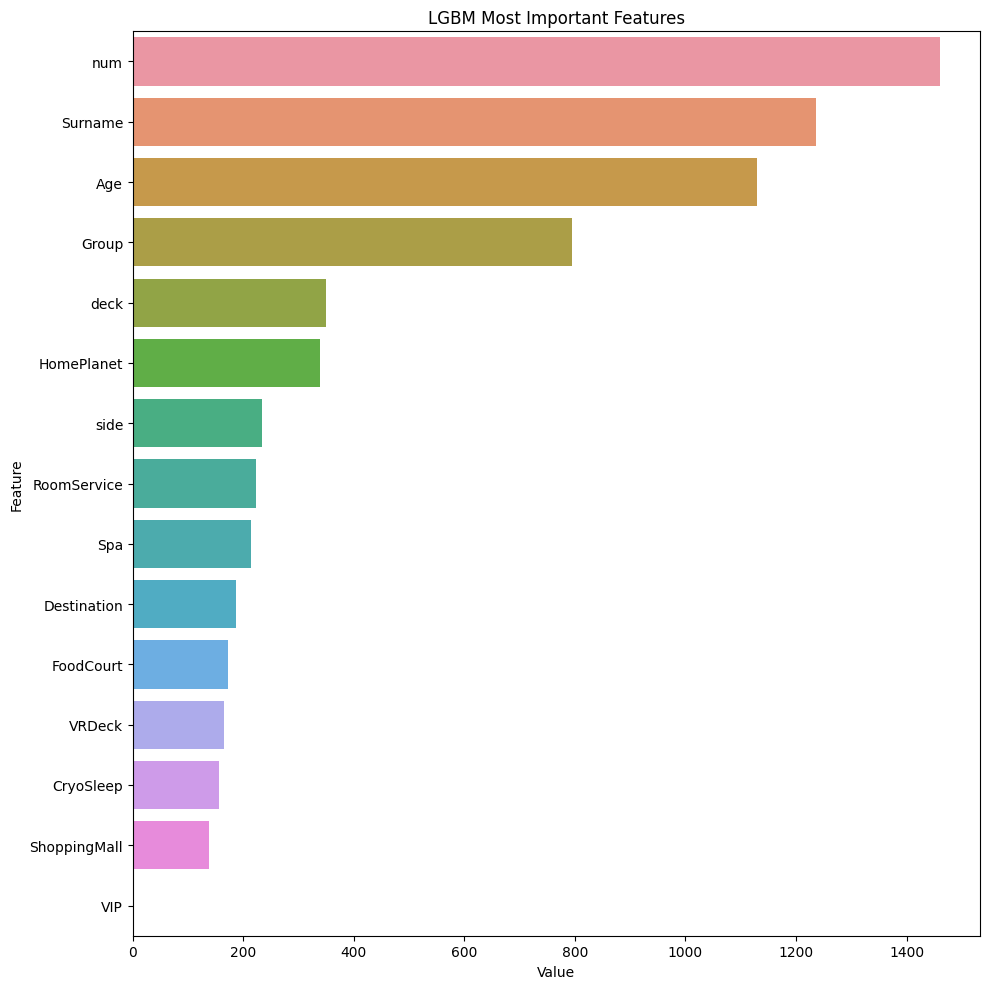

In [45]:
plot_feature_importance(model, predictors, "LGBM")

# Train XGBoost

In [46]:
score, model = train(XGBClassifier, predictors, target)
print(f"\nTEST SCORE IS {score}")

[I 2022-12-08 01:15:58,061] A new study created in memory with name: test
/home/aveitsme/envs/core/lib/python3.10/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  1%|▋                                                              | 1/100 [00:00<00:42,  2.36it/s]

[I 2022-12-08 01:15:58,485] Trial 0 finished with value: 0.8473037203721363 and parameters: {'n_estimators': 167, 'learning_rate': 0.0894660275773938, 'max_depth': 2, 'subsample': 0.5837931124654787, 'min_child_weight': 3}. Best is trial 0 with value: 0.8473037203721363.


  2%|█▎                                                             | 2/100 [00:01<01:01,  1.60it/s]

[I 2022-12-08 01:15:59,248] Trial 1 finished with value: 0.8470019347622342 and parameters: {'n_estimators': 283, 'learning_rate': 0.06668024860819044, 'max_depth': 2, 'subsample': 0.5545043972702433, 'min_child_weight': 3}. Best is trial 0 with value: 0.8473037203721363.


  3%|█▉                                                             | 3/100 [00:02<01:45,  1.08s/it]

[I 2022-12-08 01:16:00,882] Trial 2 finished with value: 0.8442592226553314 and parameters: {'n_estimators': 244, 'learning_rate': 0.03897053695811009, 'max_depth': 8, 'subsample': 0.5516452194562876, 'min_child_weight': 7}. Best is trial 0 with value: 0.8473037203721363.


  4%|██▌                                                            | 4/100 [00:03<01:32,  1.04it/s]

[I 2022-12-08 01:16:01,647] Trial 3 finished with value: 0.8471433994651159 and parameters: {'n_estimators': 142, 'learning_rate': 0.053739967181596966, 'max_depth': 6, 'subsample': 0.5546246508673819, 'min_child_weight': 7}. Best is trial 0 with value: 0.8473037203721363.


  5%|███▏                                                           | 5/100 [00:04<01:35,  1.00s/it]

[I 2022-12-08 01:16:02,724] Trial 4 finished with value: 0.8469955873735243 and parameters: {'n_estimators': 487, 'learning_rate': 0.04135592067363883, 'max_depth': 2, 'subsample': 0.6373916535978333, 'min_child_weight': 2}. Best is trial 0 with value: 0.8473037203721363.


  6%|███▊                                                           | 6/100 [00:05<01:18,  1.20it/s]

[I 2022-12-08 01:16:03,223] Trial 5 finished with value: 0.8428433944887107 and parameters: {'n_estimators': 228, 'learning_rate': 0.0470526006892916, 'max_depth': 2, 'subsample': 0.9253830331079139, 'min_child_weight': 10}. Best is trial 0 with value: 0.8473037203721363.


  7%|████▍                                                          | 7/100 [00:06<01:39,  1.07s/it]

[I 2022-12-08 01:16:04,798] Trial 6 finished with value: 0.840598749257172 and parameters: {'n_estimators': 216, 'learning_rate': 0.09041645956912178, 'max_depth': 9, 'subsample': 0.8650975041574475, 'min_child_weight': 8}. Best is trial 0 with value: 0.8473037203721363.


  8%|█████                                                          | 8/100 [00:07<01:18,  1.17it/s]

[I 2022-12-08 01:16:05,178] Trial 7 finished with value: 0.8450988121118865 and parameters: {'n_estimators': 145, 'learning_rate': 0.11551654880928416, 'max_depth': 2, 'subsample': 0.7634969007957837, 'min_child_weight': 5}. Best is trial 0 with value: 0.8473037203721363.


  9%|█████▋                                                         | 9/100 [00:09<01:57,  1.29s/it]

[I 2022-12-08 01:16:07,424] Trial 8 finished with value: 0.8322528173642351 and parameters: {'n_estimators': 308, 'learning_rate': 0.09786643324162088, 'max_depth': 8, 'subsample': 0.647606153559419, 'min_child_weight': 4}. Best is trial 0 with value: 0.8473037203721363.


 10%|██████▏                                                       | 10/100 [00:10<02:03,  1.37s/it]

[I 2022-12-08 01:16:08,988] Trial 9 finished with value: 0.8433465541292756 and parameters: {'n_estimators': 373, 'learning_rate': 0.06353057091040595, 'max_depth': 4, 'subsample': 0.7235379735082504, 'min_child_weight': 6}. Best is trial 0 with value: 0.8473037203721363.


 11%|██████▊                                                       | 11/100 [00:11<01:40,  1.13s/it]

[I 2022-12-08 01:16:09,574] Trial 10 finished with value: 0.8222091239379223 and parameters: {'n_estimators': 107, 'learning_rate': 0.00871706544428686, 'max_depth': 5, 'subsample': 0.7739052482218015, 'min_child_weight': 1}. Best is trial 0 with value: 0.8473037203721363.


 12%|███████▍                                                      | 12/100 [00:12<01:39,  1.13s/it]

[I 2022-12-08 01:16:10,713] Trial 11 finished with value: 0.8444282852328222 and parameters: {'n_estimators': 160, 'learning_rate': 0.08234215869663569, 'max_depth': 6, 'subsample': 0.5031200045631794, 'min_child_weight': 9}. Best is trial 0 with value: 0.8473037203721363.


 13%|████████                                                      | 13/100 [00:13<01:37,  1.12s/it]

[I 2022-12-08 01:16:11,784] Trial 12 finished with value: 0.8449515886351312 and parameters: {'n_estimators': 173, 'learning_rate': 0.016522390057115942, 'max_depth': 6, 'subsample': 0.636084202210005, 'min_child_weight': 5}. Best is trial 0 with value: 0.8473037203721363.


 14%|████████▋                                                     | 14/100 [00:14<01:21,  1.05it/s]

[I 2022-12-08 01:16:12,352] Trial 13 finished with value: 0.847069389715239 and parameters: {'n_estimators': 116, 'learning_rate': 0.1189685055721979, 'max_depth': 4, 'subsample': 0.5010921324139842, 'min_child_weight': 3}. Best is trial 0 with value: 0.8473037203721363.


 15%|█████████▎                                                    | 15/100 [00:15<01:18,  1.08it/s]

[I 2022-12-08 01:16:13,221] Trial 14 finished with value: 0.8460268217868586 and parameters: {'n_estimators': 180, 'learning_rate': 0.0740290256061763, 'max_depth': 4, 'subsample': 0.5932878644239854, 'min_child_weight': 7}. Best is trial 0 with value: 0.8473037203721363.


 16%|█████████▉                                                    | 16/100 [00:18<02:06,  1.51s/it]

[I 2022-12-08 01:16:16,091] Trial 15 finished with value: 0.834303604008911 and parameters: {'n_estimators': 374, 'learning_rate': 0.10364245031594627, 'max_depth': 7, 'subsample': 0.7053262979658688, 'min_child_weight': 1}. Best is trial 0 with value: 0.8473037203721363.


 17%|██████████▌                                                   | 17/100 [00:19<02:01,  1.47s/it]

[I 2022-12-08 01:16:17,452] Trial 16 finished with value: 0.8483329940533422 and parameters: {'n_estimators': 300, 'learning_rate': 0.05212092262953967, 'max_depth': 5, 'subsample': 0.9874995812681915, 'min_child_weight': 4}. Best is trial 16 with value: 0.8483329940533422.


 18%|███████████▏                                                  | 18/100 [00:20<01:57,  1.43s/it]

[I 2022-12-08 01:16:18,815] Trial 17 finished with value: 0.8439908687024097 and parameters: {'n_estimators': 356, 'learning_rate': 0.0321730567074624, 'max_depth': 3, 'subsample': 0.9822467806763033, 'min_child_weight': 3}. Best is trial 16 with value: 0.8483329940533422.


 19%|███████████▊                                                  | 19/100 [00:22<01:52,  1.39s/it]

[I 2022-12-08 01:16:20,114] Trial 18 finished with value: 0.8452443826384977 and parameters: {'n_estimators': 448, 'learning_rate': 0.024785526717957366, 'max_depth': 3, 'subsample': 0.830799539180878, 'min_child_weight': 4}. Best is trial 16 with value: 0.8483329940533422.


 20%|████████████▍                                                 | 20/100 [00:23<01:59,  1.49s/it]

[I 2022-12-08 01:16:21,830] Trial 19 finished with value: 0.8412870149278913 and parameters: {'n_estimators': 294, 'learning_rate': 0.07511968869137339, 'max_depth': 5, 'subsample': 0.850704806059139, 'min_child_weight': 4}. Best is trial 16 with value: 0.8483329940533422.


 21%|█████████████                                                 | 21/100 [00:24<01:46,  1.35s/it]

[I 2022-12-08 01:16:22,863] Trial 20 finished with value: 0.7949204678639683 and parameters: {'n_estimators': 334, 'learning_rate': 8.629250769465191e-05, 'max_depth': 3, 'subsample': 0.994974606981948, 'min_child_weight': 2}. Best is trial 16 with value: 0.8483329940533422.


 21%|█████████████                                                 | 21/100 [00:26<01:39,  1.26s/it]


[I 2022-12-08 01:16:24,473] Trial 21 finished with value: 0.8436053228396545 and parameters: {'n_estimators': 209, 'learning_rate': 0.05552885405256168, 'max_depth': 7, 'subsample': 0.6775214630821421, 'min_child_weight': 6}. Best is trial 16 with value: 0.8483329940533422.
EarlyStopping Exceeded: No new best scores on iters 20

TEST SCORE IS 0.8552138034508626


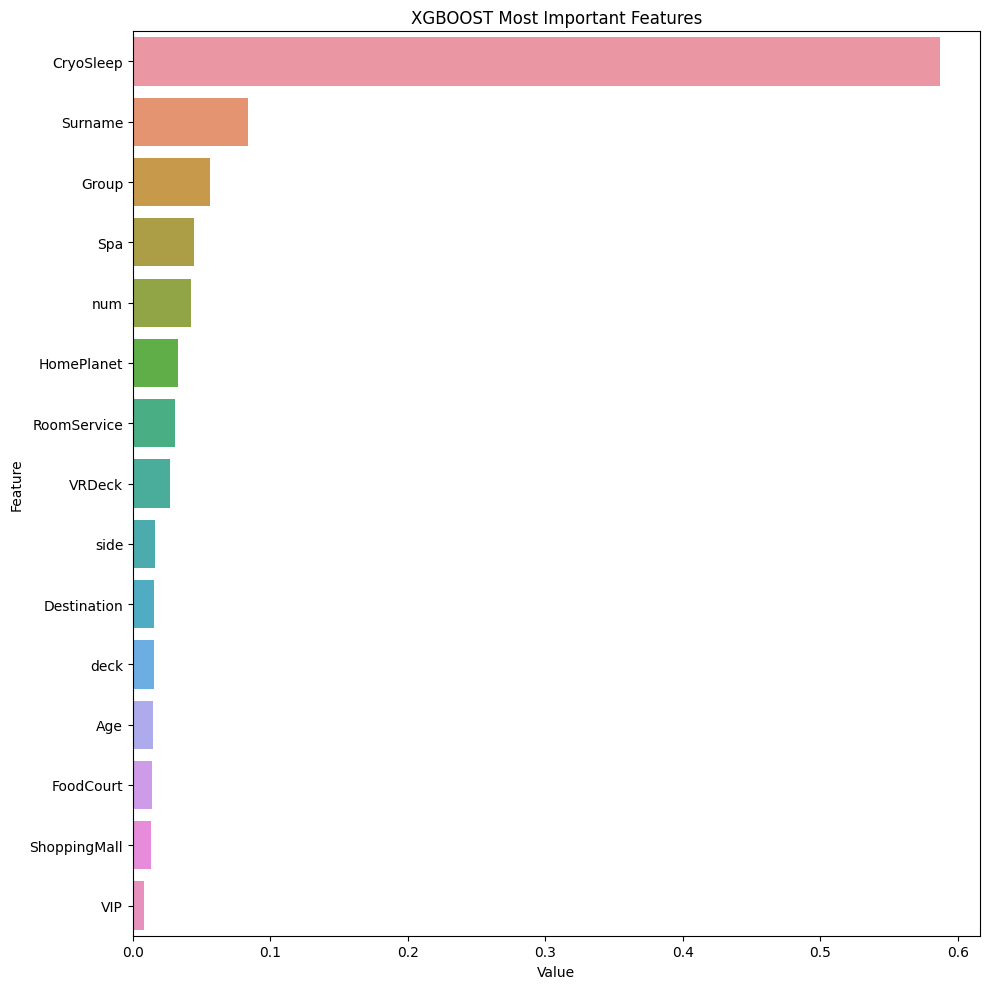

In [47]:
plot_feature_importance(model, predictors, "XGBOOST")

# References
* https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook (EN)
* https://machinelearningmastery.com/configure-gradient-boosting-algorithm/ (EN)
* https://habr.com/ru/post/540656/ (RU)
* https://github.com/optuna/optuna/issues/966 (EN)